# 1. Instalação de dependências

In [46]:
!pip install -q scikit-learn pandas joblib

# 2. Imports e configurações iniciais

In [47]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold, cross_val_score


import joblib

# 3. Função de limpeza de texto

In [48]:
#➡️ REFORMULADO PARA ENTENDER CONTRAÇÕES COMO: negação (can not), intensidade (soo) E polaridade negativa clara. EX: "I can't believe this product is soooo bad!!! 😡😡"
# SE TORNA "i can not believe this product is soo bad"


import re

def clean_text_en(text):
    if not isinstance(text, str):
        return ""

    text = text.lower()

    # Remove URLs and mentions (keep text semantics)
    text = re.sub(r"http\S+|www\S+|@\w+", " ", text)

    # Normalize common English contractions (optional but powerful)
    contractions = {
        "can't": "can not",
        "won't": "will not",
        "don't": "do not",
        "doesn't": "does not",
        "didn't": "did not",
        "isn't": "is not",
        "aren't": "are not",
        "wasn't": "was not",
        "weren't": "were not",
        "haven't": "have not",
        "hasn't": "has not",
        "hadn't": "had not",
        "couldn't": "could not",
        "shouldn't": "should not",
        "wouldn't": "would not",
        "n't": " not"
    }

    for c, expanded in contractions.items():
        text = text.replace(c, expanded)

    # Reduce character elongation (soooo → soo)
    text = re.sub(r"(.)\1{2,}", r"\1\1", text)

    # Keep only English letters and apostrophes
    text = re.sub(r"[^a-z\s']", " ", text)

    # Normalize spaces
    text = re.sub(r"\s+", " ", text).strip()

    return text


# 4. Tratamento de Negações

In [49]:
import re

def handle_negations_en(text, window=2):
    if not isinstance(text, str):
        return ""

    tokens = text.split()
    negations = {"not", "no", "never"}

    result = []
    negate = 0

    for token in tokens:
        # Reset negation at punctuation (already mostly removed, but safe)
        if re.search(r"[.!?]", token):
            negate = 0
            result.append(token)
            continue

        if token in negations:
            negate = window
            result.append(token)
            continue

        if negate > 0:
            result.append(f"NOT_{token}")
            negate -= 1
        else:
            result.append(token)

    return " ".join(result)


# 5. Tratamento de Intensificadores

In [51]:
import re

def handle_intensifiers_en(text):
    if not isinstance(text, str):
        return ""

    intensifiers = (
        r"very|really|so|too|quite|extremely|"
        r"absolutely|totally|highly|super"
    )

    adjectives = (
        r"bad|terrible|awful|poor|confusing|disappointed|"
        r"good|great|excellent|amazing|perfect|awesome"
    )

    pattern = rf"\b({intensifiers})\s+({adjectives})\b"

    text = re.sub(pattern, r"\1_\2", text)

    return text



# 6. Pipeline único de pré-processamento

6.1 Colapsar intensificador + polaridade

In [52]:
def preprocess_text(text):
  text = clean_text(text)
  text = handle_negations(text)
  text = handle_intensifiers(text)
  return text


6.2 Colapso semântico de eventos negativos

In [53]:
import re

def handle_negative_events_en(text):
    """
    Collapse noun + negative event into a single semantic token.
    Examples:
    'delivery delayed'        -> 'delivery_delayed'
    'box damaged'             -> 'box_damaged'
    'product arrived broken'  -> 'product_broken'
    """
    if not isinstance(text, str):
        return ""

    patterns = [
        # Delivery issues
        r"\b(delivery|shipping)\s+(delayed|late)",
        r"\b(shipping)\s+(took|takes)\s+(too\s+)?long",

        # Damaged product
        r"\b(box|package)\s+(damaged|broken|crushed)",
        r"\b(product|item)\s+(damaged|broken|defective)",
        r"\b(item)\s+arrived\s+(damaged|broken)",

        # Persistent problems
        r"\b(problem|issue)\s+(persists|continues|remains)",
        r"\b(still)\s+(have|having)\s+(issues|problems)",
    ]

    for p in patterns:
        text = re.sub(p, lambda m: "_".join(m.group(0).split()), text)

    return text



# 7. Normalização de colunas (fallback)

In [54]:
def normalize_columns_en(df):
    rename_map = {
        # Text column
        'texto': 'text',
        'comentario': 'text',
        'comentário': 'text',
        'review': 'text',
        'reviews': 'text',
        'comment': 'text',
        'comments': 'text',
        'sentence': 'text',
        'text': 'text',

        # Label column
        'sentimento': 'label',
        'classe': 'label',
        'rotulo': 'label',
        'rótulo': 'label',
        'sentiment': 'label',
        'label': 'label',
        'class': 'label',
        'target': 'label',
        'polarity': 'label'
    }

    # Normalize column names (lowercase + strip)
    df.columns = [c.lower().strip() for c in df.columns]

    # Rename columns if they exist
    df = df.rename(columns={
        old: new for old, new in rename_map.items() if old in df.columns
    })

    # Validate required columns
    if 'text' not in df.columns or 'label' not in df.columns:
        raise ValueError(
            "Dataset must contain text and label columns "
            "(e.g., 'text'/'review' and 'label'/'sentiment')"
        )

    return df[['text', 'label']]


# 8. Carregamento do dataset

In [55]:
from google.colab import files
import io


uploaded = files.upload()
filename = list(uploaded.keys())[0]


df = pd.read_csv(
    io.BytesIO(uploaded[filename]),
    sep=",",
    quotechar='"',
    doublequote=True,
    escapechar="\\",
    encoding="utf-8",
    engine="python",
  on_bad_lines="skip"
)


df = normalize_columns_en(df)
print("Total number of records loaded:", len(df))
display(df.head())


Saving data-en.csv to data-en.csv
Total number of records loaded: 3168


,text,label
0,"Excellent product, arrived fast and well packa...",Positive
1,"Arrived with a defect, had to return it. Awful.",Negative
2,"Delivery on time, but the packaging came crushed.",Neutral
3,"Loved it so much! Perfect color, great material.",Positive
4,"Took 20 days to arrive, never buying here again.",Negative


# 9. Limpeza e pré-processamento dos dados

In [56]:
def preprocess_en(text):
    text = clean_text_en(text)
    text = handle_negations_en(text)
    text = handle_intensifiers_en(text)
    text = handle_negative_events_en(text)
    return text


In [57]:

# Apply full English preprocessing pipeline
df['text_clean'] = df['text'].apply(preprocess_en)


# Remove empty texts after preprocessing
df = df[df['text_clean'] != ""]

# Normalize labels (US standard)
df['label'] = (
    df['label']
    .astype(str)
    .str.strip()
    .str.lower()
    .str.capitalize()
)

# Inspect class distribution
print(df['label'].value_counts())




label
Negative    1392
Positive    1146
Neutral      629
Name: count, dtype: int64


# 10. Divisão treino / teste (ANTES do oversampling)

In [58]:
X = df['text_clean']
y = df['label']


X_train, X_test, y_train, y_test = train_test_split(
X, y, test_size=0.2, random_state=42, stratify=y
)

# 11. Oversampling manual apenas no treino

In [59]:
# Oversampling manual apenas no conjunto de treino

train_df = pd.DataFrame({'text': X_train, 'label': y_train})
majority_size = train_df['label'].value_counts().max()


balanced_parts = []
for label in train_df['label'].unique():
  subset = train_df[train_df['label'] == label]
  subset_upsampled = resample(
    subset,
    replace=True,
    n_samples=majority_size,
    random_state=42
  )
  balanced_parts.append(subset_upsampled)


train_balanced = pd.concat(balanced_parts).sample(frac=1, random_state=42)
print("Distribution after oversampling (training):")
print(train_balanced['label'].value_counts())

Distribution after oversampling (training):
label
Negative    1113
Neutral     1113
Positive    1113
Name: count, dtype: int64


# 12. Vetorização TF-IDF

In [60]:
tfidf = TfidfVectorizer(
  ngram_range=(1,2),
  min_df=2,
  max_df=0.9,
  sublinear_tf=True
)


X_train_tfidf = tfidf.fit_transform(train_balanced['text'])
X_test_tfidf = tfidf.transform(X_test)


y_train_bal = train_balanced['label']

# 13. Treinamento dos modelos

In [61]:
lr_model = LogisticRegression(
  max_iter=1000,
  class_weight='balanced',
  C=1.0,
  random_state=42
)


svm_model = LinearSVC(
  class_weight='balanced',
  random_state=42
)


lr_model.fit(X_train_tfidf, y_train_bal)
svm_model.fit(X_train_tfidf, y_train_bal)

LinearSVC(class_weight='balanced', random_state=42)

# 14. Avaliação (métricas confiáveis)

In [62]:
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

print('Logistic Regression Accuracy:', accuracy_score(y_test, y_pred_lr))
print('Linear SVM Accuracy:', accuracy_score(y_test, y_pred_svm))

print('\nLogistic Regression Classification Report:\n')
print(classification_report(y_test, y_pred_lr, digits=4))

print('\nLinear SVM Classification Report:\n')
print(classification_report(y_test, y_pred_svm, digits=4))


Logistic Regression Accuracy: 0.9589905362776026
Linear SVM Accuracy: 0.9668769716088328

Logistic Regression Classification Report:

              precision    recall  f1-score   support

    Negative     0.9643    0.9677    0.9660       279
     Neutral     0.9291    0.9365    0.9328       126
    Positive     0.9692    0.9607    0.9649       229

    accuracy                         0.9590       634
   macro avg     0.9542    0.9550    0.9546       634
weighted avg     0.9591    0.9590    0.9590       634


Linear SVM Classification Report:

              precision    recall  f1-score   support

    Negative     0.9782    0.9642    0.9711       279
     Neutral     0.9520    0.9444    0.9482       126
    Positive     0.9615    0.9825    0.9719       229

    accuracy                         0.9669       634
   macro avg     0.9639    0.9637    0.9637       634
weighted avg     0.9670    0.9669    0.9669       634



# 15. Matrizes de confusão

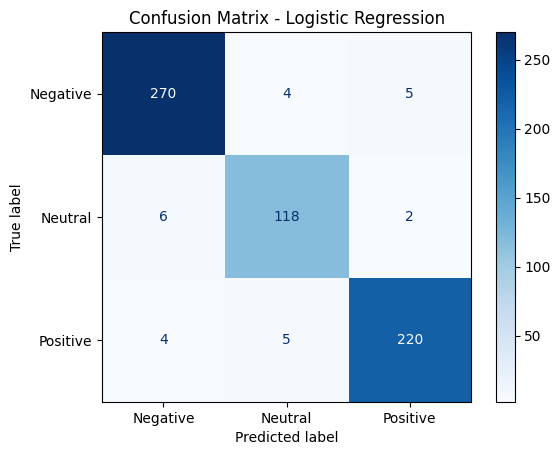

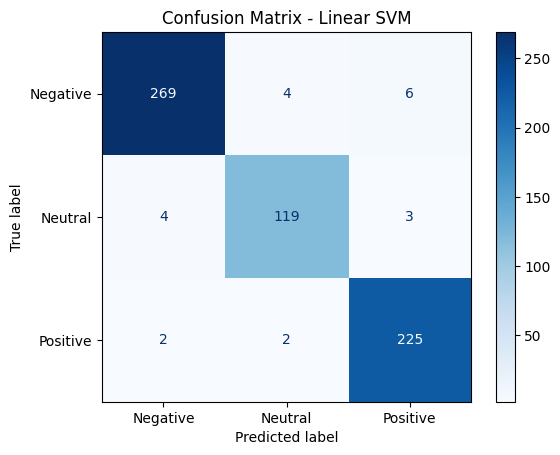

In [63]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# ===== Confusion Matrix - Logistic Regression =====
cm_lr = confusion_matrix(
    y_test,
    y_pred_lr,
    labels=lr_model.classes_
)

disp_lr = ConfusionMatrixDisplay(
    confusion_matrix=cm_lr,
    display_labels=lr_model.classes_
)

disp_lr.plot(cmap='Blues')
plt.title('Confusion Matrix - Logistic Regression')
plt.grid(False)
plt.show()


# ===== Confusion Matrix - Linear SVM =====
cm_svm = confusion_matrix(
    y_test,
    y_pred_svm,
    labels=svm_model.classes_
)

disp_svm = ConfusionMatrixDisplay(
    confusion_matrix=cm_svm,
    display_labels=svm_model.classes_
)

disp_svm.plot(cmap='Blues')
plt.title('Confusion Matrix - Linear SVM')
plt.grid(False)
plt.show()


# 16. Comparação gráfica: LR vs SVM

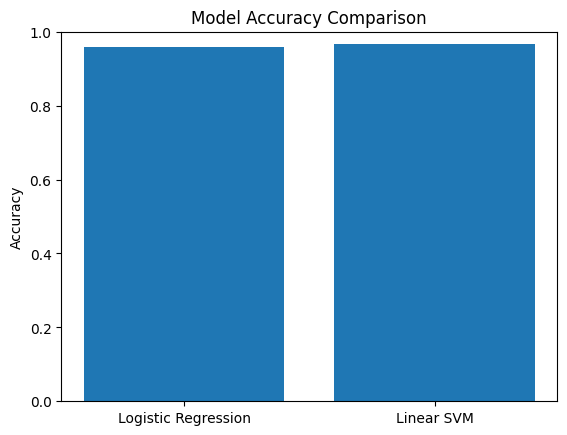

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

# Predictions (safety in case of out-of-order execution)
y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_svm = svm_model.predict(X_test_tfidf)

# Accuracy calculation
acc_lr = accuracy_score(y_test, y_pred_lr)
acc_svm = accuracy_score(y_test, y_pred_svm)

# Data for the plot
models = ['Logistic Regression', 'Linear SVM']
accuracy_scores = [acc_lr, acc_svm]

# Bar chart
plt.figure()
plt.bar(models, accuracy_scores)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.ylim(0, 1)  # standard range for classification metrics
plt.show()



# 17. Validação Cruzada Estratificada

In [65]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

lr_cv_scores = cross_val_score(
    lr_model,
    X_train_tfidf,
    y_train_bal,
    cv=skf,
    scoring='f1_macro'
)

svm_cv_scores = cross_val_score(
    svm_model,
    X_train_tfidf,
    y_train_bal,
    cv=skf,
    scoring='f1_macro'
)

print('Logistic Regression - Mean F1 Score:', lr_cv_scores.mean())
print('Linear SVM - Mean F1 Score:', svm_cv_scores.mean())


Logistic Regression - Mean F1 Score: 0.9784354674081108
Linear SVM - Mean F1 Score: 0.9877249993495288


# 18. Teste prático – frases novas

In [66]:
# ===== Model Inference Example (EN-US) =====

test_sentences = [
    "Very dissatisfied with the service. They did not solve my problem.",
    "I did not like it. The color is very different from the product photo.",
    "Weak product, it could not handle it.",
    "The delivery was extremely delayed and the box arrived damaged.",
    "Simply fantastic, it exceeded all my expectations!",
    "It arrived broken, I want my money back immediately."
]

# Unified preprocessing pipeline
processed_sentences = [
    handle_negative_events_en(
        handle_intensifiers_en(
            handle_negations_en(
                clean_text_en(sentence)
            )
        )
    )
    for sentence in test_sentences
]

# Vectorization
sentences_vec = tfidf.transform(processed_sentences)

# Predictions
predictions = lr_model.predict(sentences_vec)
confidence = lr_model.predict_proba(sentences_vec).max(axis=1)

# Results
pd.DataFrame({
    'Text': test_sentences,
    'Prediction': predictions,
    'Confidence': confidence
})


,Text,Prediction,Confidence
0,Very dissatisfied with the service. They did n...,Negative,0.839763
1,I did not like it. The color is very different...,Negative,0.579282
2,"Weak product, it could not handle it.",Negative,0.822059
3,The delivery was extremely delayed and the box...,Negative,0.667549
4,"Simply fantastic, it exceeded all my expectati...",Positive,0.795490
5,"It arrived broken, I want my money back immedi...",Negative,0.473834


# 19. Salvando modelos

In [67]:
import os
import joblib

os.makedirs("models", exist_ok=True)

joblib.dump(lr_model, "models/en_model.pkl")
joblib.dump(tfidf, "models/en_tfidf.pkl")

print("Modelo e TF-IDF em inglês salvos com sucesso 🇺🇸")


Modelo e TF-IDF em inglês salvos com sucesso 🇺🇸
